##  Car Price Project - Algorithms

In [1]:
import time
start = time.time()

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import re
import pprint
import joblib

#pd.set_option('max_colwidth', 2000)
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

#Distributions supporting rvs method
from scipy.stats import randint
from scipy.stats import uniform
from skopt.space import Real

#Feature selection
from eli5.sklearn import PermutationImportance
import eli5

#transformers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

#Model selection
from sklearn.base import clone
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

#Anomaly detection for outliers.
from sklearn.ensemble import IsolationForest

#Models for prediction
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import lightgbm as lgb

#Scoring
from sklearn.metrics import mean_squared_error

C:\Users\Justin\Anaconda3\envs\ds_env\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Justin\Anaconda3\envs\ds_env\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Justin\Anaconda3\envs\ds_env\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feat

In [2]:
def scale_num_df(train_df, test_df, numer_cols, scaler):
    '''Scale train.  Transform test with the same scaling stats.
    Returns scaled train and scaled test.'''
    scaled_trn_num_df = pd.DataFrame(scaler.fit_transform(train_df[numer_cols]))
    scaled_trn_num_df.index=train_df.index
    scaled_trn_num_df.columns=train_df[numer_cols].columns
    
    scaled_tst_num_df = pd.DataFrame(scaler.transform(test_df[numer_cols]))
    scaled_tst_num_df.index=test_df.index
    scaled_tst_num_df.columns=test_df[numer_cols].columns
    return scaled_trn_num_df, scaled_tst_num_df

In [3]:
#Score predictions of fitted model.
def score_algo(model, X, y, prediction):
    print('-----------------------------------------------')
    print(f'##### {type(model).__name__} - Prediction Scores:')
    print('-----------------------------------------------')
    print('RMSE:', round(np.sqrt(mean_squared_error(y, prediction)), 1))
    print(' R^2:', round(r2_score(y, prediction), 4))
    print(' MAE:', round(mean_absolute_error(y, prediction),1))

In [4]:
def get_PCA(train, test):
    '''
    Takes numeric dataframe and returns principal components dataframes with
    same shape, indices, and numbered column names. Retun trainPC, testPC,
    and cumulative sum of explained variance.
    '''
    pca = PCA(n_components=None)
    trainPC = pca.fit_transform(train)  #get train PC
    trainPC = pd.DataFrame(trainPC, index=train.index).add_prefix('PC')
    trnCumSum=np.cumsum(pca.explained_variance_ratio_)
    testPC = pca.transform(test)        #test is projected on the PCs previously extracted from train
    testPC = pd.DataFrame(testPC, index=test.index).add_prefix('PC')
    return trainPC, testPC, trnCumSum

In [5]:
def one_hot_encode(train_df, test_df, cat_cols):
    '''
    One-Hot Encode train category columns.  Apply identical encoding to test.
    Unknown category for test handled by returning all zeroes column.  Function
    keeps original dataframe indices intact.
    '''
    from sklearn.preprocessing import OneHotEncoder
    ohe = OneHotEncoder(sparse=False, drop=None, handle_unknown='ignore')  #drop None or 'first'
    #ohe = OneHotEncoder(sparse=False, drop='first', handle_unknown='error')  #drop None or 'first'
    #fit_transform train cat_cols.
    ohe_train_df=pd.DataFrame(ohe.fit_transform(train_df[cat_cols]))
    ohe_train_df.index=train_df.index
    ohe_train_df.columns=ohe.get_feature_names(cat_cols)
    #Transform test.  Categories exclusive to train get zeros in test.  Categories exclusive to test are omitted.
    ohe_test_df=pd.DataFrame(ohe.transform(test_df[cat_cols]))
    ohe_test_df.index=test_df.index
    ohe_test_df.columns=ohe.get_feature_names(cat_cols)
    return ohe_train_df, ohe_test_df

In [6]:
def query_table_to_df(dbname_string, query):  
    '''Query sqlite database and return DataFrame.'''
    with sqlite3.connect(dbname_string) as conn: # autocommit mode
        return pd.read_sql(sql=query, con=conn, index_col='index')

In [7]:
#Load data
vehicle = joblib.load('vehicle.joblib')  #contains sqlite-incompatible data
train=query_table_to_df('auto.sqlite','SELECT * from trainClean')
test=query_table_to_df('auto.sqlite','SELECT * from testClean')
train.index.name=None
test.index.name=None

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 346 entries, 1832 to 261
Data columns (total 13 columns):
Location         346 non-null object
Year             346 non-null int64
Odometer         346 non-null float64
Make             346 non-null object
Model            346 non-null object
Trim             346 non-null object
Seller           346 non-null object
Price            346 non-null float64
Model_Trim       346 non-null object
Model_Seller     346 non-null object
Trim_Seller      346 non-null object
Year^2           346 non-null int64
Year_Odometer    346 non-null float64
dtypes: float64(3), int64(2), object(8)
memory usage: 37.8+ KB


##  Nonlinear Models - LightGBM

### Convert categories to numbers

In [9]:
#Target encode features with train targets.

from category_encoders.target_encoder import TargetEncoder

encode_cols = ['Location', 'Make', 'Model', 'Trim', 'Seller', 'Model_Trim', 'Model_Seller', 'Trim_Seller']
def target_encode_categorical(train, test, target, encoder):
    '''Returns encoded categorical features.  Encoded feature is a blend of
    (1) ExpectedVal( trainTarget | FeatureClass) and (2) "Prior": ExpectedVal(Target)
    over all training data.  Set testTarget to NaN to stop leakage. 
    
    Encoder smoothing balances Class average vs Prior. Higher smoothing is stronger
    regularization.
    
    Arguments
    ---------
    train: training data including target Y
    test: test data including target Y
    target: target Y
    encoder: TargetEncoder(cols_to encode, smoothing_float_value).  
    See https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html
    for more hyperparameters.'''
    
    if target in test.columns:   #Omit any test targets from encoding.  Prevents leakage.
        test_target_bak = test[target].copy()
        test[target] = np.nan  
    full = train.append(test)
    fullX = full.copy()
    fullY = fullX.pop(target)
    fullX_enc = encoder.fit_transform(fullX, fullY)
    #Overwrite train/test features with encoded features.  Restore test target.
    train[encode_cols] = fullX_enc.loc[train.index, encode_cols]
    test[encode_cols] = fullX_enc.loc[test.index, encode_cols]
    test[target] = test_target_bak
    #display(train.isnull().sum().sort_values(ascending=False))
    #display(test.isnull().sum().sort_values(ascending=False))
    return train, test    
    
train_lenc, test_lenc=target_encode_categorical(train,test,'Price', 
                                                    TargetEncoder(cols=encode_cols, smoothing=0.05))

In [10]:
#LightGBM model: Encode train/test categories as integers.  
#https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.train.html#lightgbm.train
def encode_cat_to_int(train, test):
    cat_train = train.select_dtypes(['object'])
    if len(cat_train.columns) == 0:
        print('### No categorical features to encode. ###')
        return  #Dont overwrite train and test
    for c in cat_train.columns:
        from sklearn.preprocessing import LabelEncoder
        le=LabelEncoder()
        #Fit encoder on all possible categories in train & test
        le.fit(train[c].values.tolist() + test[c].values.tolist())
        #Return encoding to column in train and column in test.
        train[c]=le.transform(train[c].values.tolist())
        test[c]=le.transform(test[c].values.tolist())
    return train, test

#encode_cat_to_int overwrites the passed DataFrame -- use DataFrame copy instead.
#train_lenc, test_lenc = encode_cat_to_int(train=train.copy(), test=test.copy())

In [11]:
def freq_encode_col(train, test, encode_cols):
    '''Get frequency of each target feature.
       Return train with transformed features.'''
    #cat_cols = train.select_dtypes('object').columns
    for col in encode_cols:
        train[col] = train.groupby([col])[col].transform('count')
        test[col] = test.groupby([col])[col].transform('count')
    return train, test
#train_lenc, test_lenc = freq_encode_col(train_lenc.copy(), test_lenc.copy(), encode_cols=['Model_Trim'])

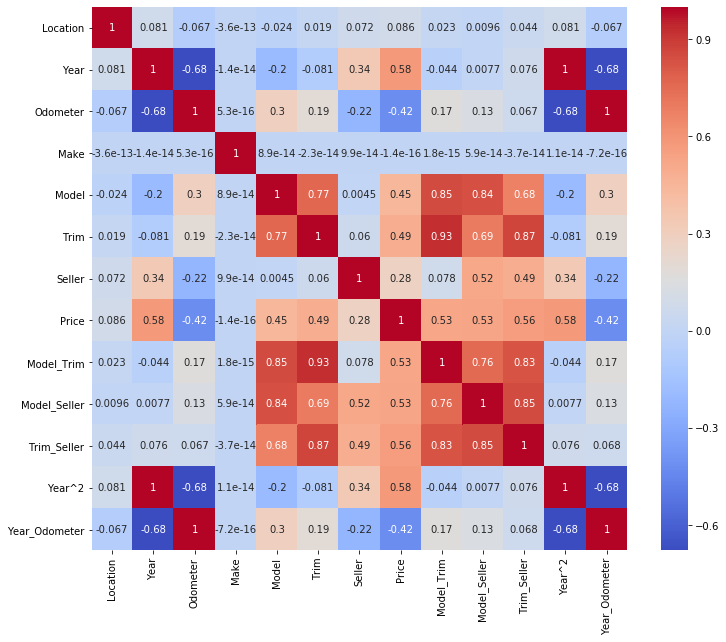

In [12]:
#Show correlation heatmap.  Keeping the collinear features may help prediction, while making the 
#linear regression coefficients less interpretable.
plt.figure(figsize=(12,10))
sns.heatmap(train_lenc.corr(), cmap='coolwarm', annot=True)
plt.show()

<a id='section_id1'></a>

### Detect Anomalies with Isolation Forest

In [13]:
train_lenc.head(1)

,Location,Year,Odometer,Make,Model,Trim,Seller,Price,Model_Trim,Model_Seller,Trim_Seller,Year^2,Year_Odometer
5764,17629.241379,2016,55843.0,17905.231362,18513.182174,17671.05364,19730.251599,25250.0,19750.125,20353.863346,19717.112981,4064256,112579488.0


In [14]:
def get_anomalies(train, test, drop_test_anom=True):
    '''Drop anomalies from train and test.'''
    #Instantiate, fit, and predict with Isolation Forest.
    isof = IsolationForest(n_estimators = 200, max_samples = 256, max_features=1.0, contamination=0.05, behaviour='new', n_jobs=-1, random_state=33)
    trn_preds = isof.fit_predict(train)
    tst_preds = isof.predict(test)

    #Save outliers (-1) to indexed series.
    trn_preds = pd.Series(data=trn_preds, index=train.index, name='OutlierTrn')
    trn_anom = trn_preds[trn_preds == -1]
    tst_preds = pd.Series(data=tst_preds, index=test.index, name='OutlierTst')
    tst_anom = tst_preds[tst_preds == -1]

    #Drop anomalies.
    trn_drops = trn_anom.index
    print(f'{len(trn_drops)} train anomalies flagged by Isolation Forest:', trn_drops)
        
    if drop_test_anom == True:
        tst_drops = tst_anom.index
        print(f'{len(tst_drops)} test anomalies flagged by Isolation Forest:', tst_drops)
    else:
        tst_drops = 'None_dropped'
        print(f'\nAnomaly flagging of test disabled:', tst_drops)
    return trn_drops, tst_drops

In [15]:
#Print train and test anomalies.  Assumes same contamination level.
train_anom, test_anom  = get_anomalies(train=train_lenc, test=test_lenc, drop_test_anom=True)

C:\Users\Justin\Anaconda3\envs\ds_env\lib\site-packages\sklearn\ensemble\_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


156 train anomalies flagged by Isolation Forest: Int64Index([ 4683,  1543, 10465,  2005,  7880,  5070,  2798,  5112,  8708,
             3620,
            ...
             8603, 10030,  8311,  8714,  8156,  5131,   800,  7017,  5883,
              458],
           dtype='int64', length=156)
13 test anomalies flagged by Isolation Forest: Int64Index([8472, 10445, 1717, 10514, 8213, 10338, 3029, 1505, 7672, 6017, 201,
            3451, 4738],
           dtype='int64')


In [16]:
#Drop anomalies from LightGBM data.
# train_lenc.drop(index = train_anom, inplace=True, errors = 'ignore')
# test_lenc.drop(index = test_anom, inplace=True, errors = 'ignore')

In [17]:
train_lenc.head(3)

,Location,Year,Odometer,Make,Model,Trim,Seller,Price,Model_Trim,Model_Seller,Trim_Seller,Year^2,Year_Odometer
5764,17629.241379,2016,55843.0,17905.231362,18513.182174,17671.053640,19730.251599,25250.0,19750.125000,20353.863346,19717.112981,4064256,112579488.0
3229,17728.448894,2016,47114.0,17905.231362,14921.681416,10088.533958,19730.251599,13989.0,14512.529412,15145.858491,11200.686747,4064256,94981824.0
7541,17629.241379,2012,136985.0,17905.231362,8253.577640,10088.533958,19730.251599,5454.0,8253.577640,9503.008929,11200.686747,4048144,275613820.0


### LightGBM with label encoding

In [18]:
#Split out Price
trainX_lenc = train_lenc.copy()
trainY_lenc =trainX_lenc.pop('Price')
testX_lenc = test_lenc.copy()
testY_lenc = testX_lenc.pop('Price')

In [19]:
#Scale X numeric columns.
#trainX_lenc, testX_lenc = scale_num_df(trainX_lenc, testX_lenc, trainX_lenc.columns, MinMaxScaler())

In [20]:
trainX_lenc.head()

,Location,Year,Odometer,Make,Model,Trim,Seller,Model_Trim,Model_Seller,Trim_Seller,Year^2,Year_Odometer
5764,17629.241379,2016,55843.0,17905.231362,18513.182174,17671.053640,19730.251599,19750.125000,20353.863346,19717.112981,4064256,112579488.0
3229,17728.448894,2016,47114.0,17905.231362,14921.681416,10088.533958,19730.251599,14512.529412,15145.858491,11200.686747,4064256,94981824.0
7541,17629.241379,2012,136985.0,17905.231362,8253.577640,10088.533958,19730.251599,8253.577640,9503.008929,11200.686747,4048144,275613820.0
1746,17728.448894,2015,85000.0,17905.231362,16337.515152,17887.061224,12325.475880,17887.061224,12859.972973,13892.306667,4060225,171275000.0
5654,17629.241379,2016,73108.0,17905.231362,18513.182174,22130.691589,19730.251599,19510.607143,20353.863346,24896.876712,4064256,147385728.0


In [21]:
#CREATE LightGBM model with random search.

clf = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', n_jobs=1, silent=1)

param_grid={"learning_rate": Real(0.01, 1.0, 'log-uniform'),
            "n_estimators": randint(100,150),
            "num_leaves": randint(2, 600), 
            "max_depth": randint(0, 40),
            "min_data_in_leaf": randint(10, 200),  #prevents overfitting
            "max_bin": randint(100,60000),
            "bagging_fraction": Real(0.01, 0.1, 'uniform'),
            "feature_fraction": uniform(0.01, 0.99),
            "subsample_for_bin": randint(100000, 600000),
            "lambda_l2": Real(1e-9, 1000, 'log-uniform'),
            "lambda_l1": Real(1e-9, 1, 'log-uniform'),          
            }

#Instantiate random_search.
rs_cv = RandomizedSearchCV(clf, param_distributions=param_grid,\
                                   n_iter=35, n_jobs=-1, cv=5, scoring='neg_mean_absolute_error',\
                                   iid=False, return_train_score=False,random_state=40)

#Tune clf with CV.
rs_cv.fit(trainX_lenc, trainY_lenc)

#Tuned model best score.
best_score = rs_cv.best_score_
best_score_std = rs_cv.cv_results_['std_test_score'][rs_cv.best_index_]
best_hyperparams = rs_cv.best_params_
print(f'## Grid iters checked: {len(rs_cv.cv_results_["params"])}')
print(f'## best CV score: {best_score:.4f} +- {best_score_std:.4f}\n')
print('## Best parameters:')
pprint.pprint(best_hyperparams)

## Grid iters checked: 35
## best CV score: -2824.7875 +- 81.6441

## Best parameters:
{'bagging_fraction': array([0.06267572]),
 'feature_fraction': 0.8449265515495977,
 'lambda_l1': array([0.00191179]),
 'lambda_l2': array([0.03977551]),
 'learning_rate': array([0.15483176]),
 'max_bin': 32602,
 'max_depth': 37,
 'min_data_in_leaf': 95,
 'n_estimators': 125,
 'num_leaves': 176,
 'subsample_for_bin': 325177}


C:\Users\Justin\Anaconda3\envs\ds_env\lib\site-packages\sklearn\model_selection\_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [22]:
#PREDICT model.
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
y_predictions = rs_cv.predict(testX_lenc)
score_algo(rs_cv, testY_lenc, testY_lenc, y_predictions)

-----------------------------------------------
##### RandomizedSearchCV - Prediction Scores:
-----------------------------------------------
RMSE: 3389.4
 R^2: 0.887
 MAE: 2338.9


In [23]:
trainX_lenc.head(2)

,Location,Year,Odometer,Make,Model,Trim,Seller,Model_Trim,Model_Seller,Trim_Seller,Year^2,Year_Odometer
5764,17629.241379,2016,55843.0,17905.231362,18513.182174,17671.053640,19730.251599,19750.125000,20353.863346,19717.112981,4064256,112579488.0
3229,17728.448894,2016,47114.0,17905.231362,14921.681416,10088.533958,19730.251599,14512.529412,15145.858491,11200.686747,4064256,94981824.0


In [24]:
#Get feature importances using eli5.
perm = PermutationImportance(rs_cv,n_iter=4).fit(testX_lenc, testY_lenc)
eli5.show_weights(perm, feature_names = testX_lenc.columns.tolist())

Weight,Feature
4043.4941 ± 199.8800,Year
2213.0546 ± 394.3432,Model
1215.9749 ± 65.2601,Odometer
983.5156 ± 176.5413,Trim_Seller
903.5439 ± 172.6607,Trim
765.7716 ± 177.5940,Model_Trim
541.1008 ± 40.1451,Model_Seller
433.9229 ± 103.3442,Year^2
176.7518 ± 76.4987,Year_Odometer
95.9474 ± 35.3135,Location


#### Residuals Plot - format explanation: http://www.win-vector.com/blog/2019/09/why-do-we-plot-predictions-on-the-x-axis/

In [25]:
def plot_residuals(predicted, true):
    '''
    Plots predicted vs error.  Error = true - predicted.  Marks
    three standard deviation error from mean with orange bars.  
    Plots histogram.  Prints error statistics.
    '''
    error = true - predicted
    print('error count:', len(error), '| error avg:', round(error.mean(),1), '| high pred percent:', round(100*len(error[error<0])/len(error),1), '| low pred percent:', round(100*len(error[error>=0])/len(error),1), )
    mean = np.mean(error)
    z=(error-mean)/np.std(error)
    three_std = 3* np.std(error)
    upper_lim = mean + three_std
    lower_lim = mean - three_std
    fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10,30))
    sns.set(font_scale=1.3)
    sns.scatterplot(x=predicted, y=error, ax=ax1, color='black')    
    ax1.set_title('Scatterplot: Predicted vs Error')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Error - True less Predicted')
    ax1.axhline(y=0, color='g', ls='--', alpha=0.8)
    ax1.axhline(y=upper_lim, color='orange', ls='--', alpha=0.8)
    ax1.axhline(y=lower_lim, color='orange', ls='--', alpha=0.8)
    
    for elem in range(0, predicted.shape[0]):  #add iloc for error outside limits. 's=' is the text string.
        x_val = predicted[elem]     #assume predicted is numpy.ndarray
        y_val = error.values[elem]  #assume error is Series
        label_str = str(elem)       #iloc
        if (y_val > upper_lim or y_val < lower_lim):        
            ax1.text(x=x_val+500, y=y_val-400, s=label_str, horizontalalignment = 'left', size=14, color='r')
    
    sns.distplot(error, ax=ax2, kde=True)
    ax2.set_title('Histogram: Error - True Less Predicted')
    ax2.set_xlabel('Error')
    ax2.set_ylabel('Frequency')
    ax2.axvline(x=0, color='black', ls='--', alpha=0.8)
    
    sns.regplot(x=predicted, y=true, ax=ax3, color='black', marker='.', ci=None)
    ax3.set_title('Linear Regression Plot: Predicted vs True')
    ax3.set_xlabel('Predicted')
    ax3.set_ylabel('True')

error count: 346 | error avg: -180.3 | high pred percent: 50.0 | low pred percent: 50.0


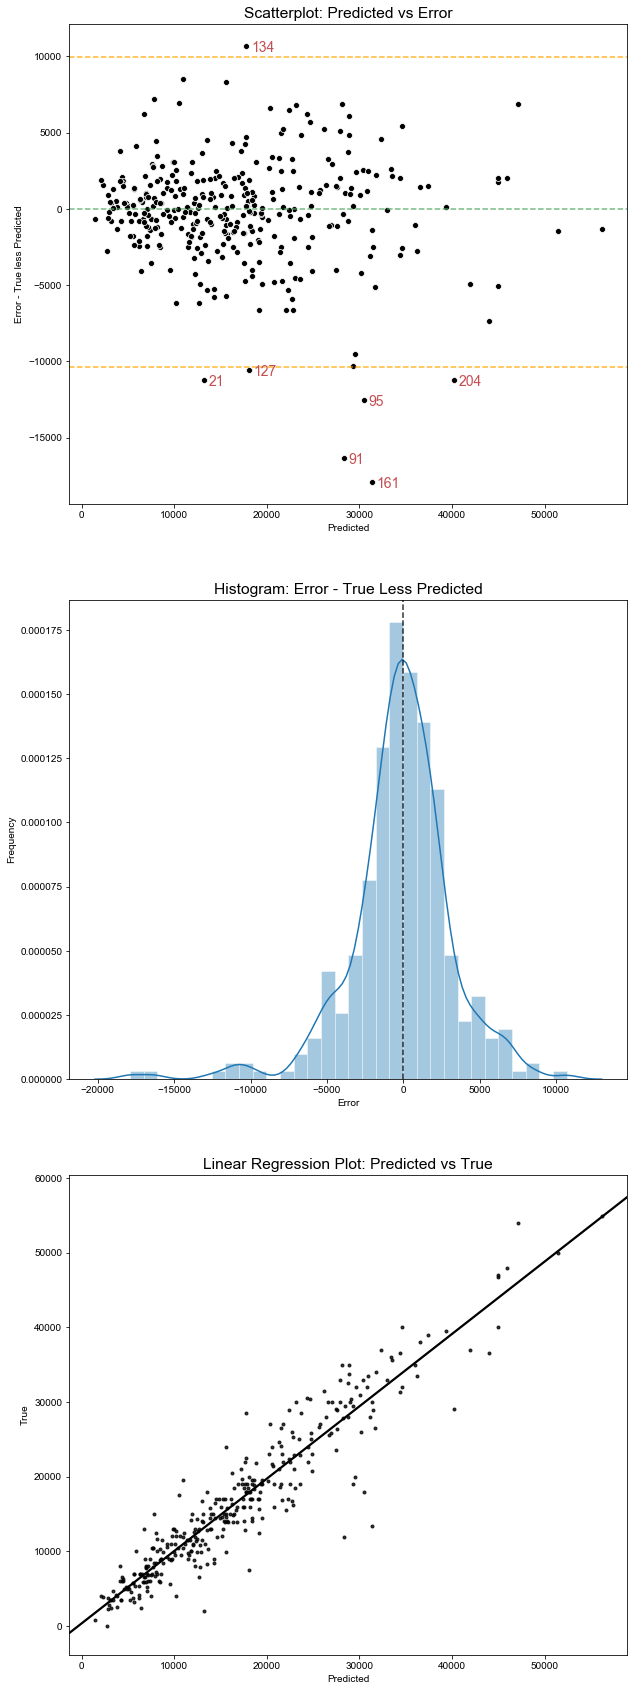

In [26]:
plot_residuals(predicted=y_predictions, true=testY_lenc)

## DEBUG OUTLIERS

In [27]:
# #Review iloc
# pd.set_option('max_colwidth', 100)
# for inum in [19,465,232]:
#     display('### modeled test:', test.iloc[[inum]])
#     print('predicted:', y_predictions[inum])
#     print('error:', testY.iloc[inum] - y_predictions[inum])
#     display('### original:', vehicle.loc[[test.iloc[inum:inum+1].index[0]]])
#     print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')

In [28]:
# #Examples in train
# train[(train['Year'] == 2017) & (train['Model'] == 'f-350') & (train['Trim'] == 'super')]

In [29]:
# #Examples in vehicle
# vehicle[(vehicle['Year'] == 2005) & (vehicle['Model'] == 'mustang') & (vehicle['Trim'] == 'None')]

In [30]:
# pd.set_option('max_colwidth', 100)
# vehicle.loc[[5053, 4637, 4934,6459]]

## Linear Model data

In [31]:
train=query_table_to_df('auto.sqlite','SELECT * from trainClean')
test=query_table_to_df('auto.sqlite','SELECT * from testClean')
train.index.name=None
test.index.name=None
train.shape

(3112, 13)

In [32]:
#Drop Isolation Forest anomalies from regression data.
# train.drop(index = train_anom, inplace=True, errors = 'ignore')
# test.drop(index = test_anom, inplace=True, errors = 'ignore')

[Go To Isolation Forest](#section_id1)

In [33]:
#Split out Price
trainX = train.copy()
trainY =trainX.pop('Price')
testX = test.copy()
testY = testX.pop('Price')

### One-Hot Encode

In [34]:
#Get One-Hot columns for the specified categ_columns.
categ_cols= trainX.select_dtypes('object').columns.values
ohe_train_df, ohe_test_df = one_hot_encode(train_df=trainX, test_df=testX, cat_cols=categ_cols)

In [35]:
print(ohe_train_df.shape)
ohe_train_df.head(2)

(3112, 157)


,Location_austin,Location_dallas,Location_elpaso,Location_houston,Location_sanantonio,Make_ford,Model_edge,Model_escape,Model_expedition,Model_explorer,Model_f-150,Model_f-250,Model_f-350,Model_fiesta,Model_focus,Model_fusion,Model_mustang,Model_transit,Trim_4x4,Trim_cargo,Trim_connect,Trim_convertible,Trim_coupe,Trim_diesel,Trim_ecoboost,Trim_eddie,Trim_edge,Trim_fx2,Trim_fx4,Trim_gt,Trim_king,Trim_lariat,Trim_limited,Trim_platinum,Trim_se,Trim_sport,Trim_super,Trim_super duty,Trim_supercab,Trim_supercrew,Trim_titanium,Trim_xl,Trim_xlt,Seller_dealer,Seller_owner,Model_Trim_edge_edge,Model_Trim_escape_se,Model_Trim_escape_titanium,Model_Trim_expedition_eddie,Model_Trim_expedition_limited,Model_Trim_expedition_xlt,Model_Trim_explorer_limited,Model_Trim_explorer_sport,Model_Trim_explorer_xlt,Model_Trim_f-150_4x4,Model_Trim_f-150_fx2,Model_Trim_f-150_fx4,Model_Trim_f-150_king,Model_Trim_f-150_lariat,Model_Trim_f-150_platinum,Model_Trim_f-150_super,Model_Trim_f-150_supercab,Model_Trim_f-150_supercrew,Model_Trim_f-150_xl,Model_Trim_f-150_xlt,Model_Trim_f-250_diesel,Model_Trim_f-250_king,Model_Trim_f-250_lariat,Model_Trim_f-250_super,Model_Trim_f-250_super duty,Model_Trim_f-250_xlt,Model_Trim_f-350_super,Model_Trim_f-350_super duty,Model_Trim_fiesta_se,Model_Trim_focus_se,Model_Trim_fusion_se,Model_Trim_fusion_titanium,Model_Trim_mustang_convertible,Model_Trim_mustang_coupe,Model_Trim_mustang_ecoboost,Model_Trim_mustang_gt,Model_Trim_transit_cargo,Model_Trim_transit_connect,Model_Seller_edge_dealer,Model_Seller_edge_owner,Model_Seller_escape_dealer,Model_Seller_escape_owner,Model_Seller_expedition_dealer,Model_Seller_expedition_owner,Model_Seller_explorer_dealer,Model_Seller_explorer_owner,Model_Seller_f-150_dealer,Model_Seller_f-150_owner,Model_Seller_f-250_dealer,Model_Seller_f-250_owner,Model_Seller_f-350_dealer,Model_Seller_f-350_owner,Model_Seller_fiesta_dealer,Model_Seller_fiesta_owner,Model_Seller_focus_dealer,Model_Seller_focus_owner,Model_Seller_fusion_dealer,Model_Seller_fusion_owner,Model_Seller_mustang_dealer,Model_Seller_mustang_owner,Model_Seller_transit_dealer,Model_Seller_transit_owner,Trim_Seller_4x4_dealer,Trim_Seller_4x4_owner,Trim_Seller_cargo_dealer,Trim_Seller_cargo_owner,Trim_Seller_connect_dealer,Trim_Seller_connect_owner,Trim_Seller_convertible_dealer,Trim_Seller_convertible_owner,Trim_Seller_coupe_dealer,Trim_Seller_coupe_owner,Trim_Seller_diesel_dealer,Trim_Seller_diesel_owner,Trim_Seller_ecoboost_dealer,Trim_Seller_ecoboost_owner,Trim_Seller_eddie_dealer,Trim_Seller_eddie_owner,Trim_Seller_edge_dealer,Trim_Seller_edge_owner,Trim_Seller_fx2_dealer,Trim_Seller_fx2_owner,Trim_Seller_fx4_dealer,Trim_Seller_fx4_owner,Trim_Seller_gt_dealer,Trim_Seller_gt_owner,Trim_Seller_king_dealer,Trim_Seller_king_owner,Trim_Seller_lariat_dealer,Trim_Seller_lariat_owner,Trim_Seller_limited_dealer,Trim_Seller_limited_owner,Trim_Seller_platinum_dealer,Trim_Seller_platinum_owner,Trim_Seller_se_dealer,Trim_Seller_se_owner,Trim_Seller_sport_dealer,Trim_Seller_sport_owner,Trim_Seller_super duty_dealer,Trim_Seller_super duty_owner,Trim_Seller_super_dealer,Trim_Seller_super_owner,Trim_Seller_supercab_dealer,Trim_Seller_supercab_owner,Trim_Seller_supercrew_dealer,Trim_Seller_supercrew_owner,Trim_Seller_titanium_dealer,Trim_Seller_titanium_owner,Trim_Seller_xl_dealer,Trim_Seller_xl_owner,Trim_Seller_xlt_dealer,Trim_Seller_xlt_owner
5764,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [36]:
#Drop original category columns.  Concatenate the One-Hot columns.
trainX = trainX.drop(columns=categ_cols, axis='columns', errors='ignore')
testX = testX.drop(columns=categ_cols, axis='columns', errors='ignore')

trainX = pd.concat([trainX, ohe_train_df], axis='columns')
testX = pd.concat([testX, ohe_test_df], axis='columns')
display('trainX:', trainX.head(2))
display('testX:', testX.head(2))

'trainX:'

,Year,Odometer,Year^2,Year_Odometer,Location_austin,Location_dallas,Location_elpaso,Location_houston,Location_sanantonio,Make_ford,Model_edge,Model_escape,Model_expedition,Model_explorer,Model_f-150,Model_f-250,Model_f-350,Model_fiesta,Model_focus,Model_fusion,Model_mustang,Model_transit,Trim_4x4,Trim_cargo,Trim_connect,Trim_convertible,Trim_coupe,Trim_diesel,Trim_ecoboost,Trim_eddie,Trim_edge,Trim_fx2,Trim_fx4,Trim_gt,Trim_king,Trim_lariat,Trim_limited,Trim_platinum,Trim_se,Trim_sport,Trim_super,Trim_super duty,Trim_supercab,Trim_supercrew,Trim_titanium,Trim_xl,Trim_xlt,Seller_dealer,Seller_owner,Model_Trim_edge_edge,Model_Trim_escape_se,Model_Trim_escape_titanium,Model_Trim_expedition_eddie,Model_Trim_expedition_limited,Model_Trim_expedition_xlt,Model_Trim_explorer_limited,Model_Trim_explorer_sport,Model_Trim_explorer_xlt,Model_Trim_f-150_4x4,Model_Trim_f-150_fx2,Model_Trim_f-150_fx4,Model_Trim_f-150_king,Model_Trim_f-150_lariat,Model_Trim_f-150_platinum,Model_Trim_f-150_super,Model_Trim_f-150_supercab,Model_Trim_f-150_supercrew,Model_Trim_f-150_xl,Model_Trim_f-150_xlt,Model_Trim_f-250_diesel,Model_Trim_f-250_king,Model_Trim_f-250_lariat,Model_Trim_f-250_super,Model_Trim_f-250_super duty,Model_Trim_f-250_xlt,Model_Trim_f-350_super,Model_Trim_f-350_super duty,Model_Trim_fiesta_se,Model_Trim_focus_se,Model_Trim_fusion_se,Model_Trim_fusion_titanium,Model_Trim_mustang_convertible,Model_Trim_mustang_coupe,Model_Trim_mustang_ecoboost,Model_Trim_mustang_gt,Model_Trim_transit_cargo,Model_Trim_transit_connect,Model_Seller_edge_dealer,Model_Seller_edge_owner,Model_Seller_escape_dealer,Model_Seller_escape_owner,Model_Seller_expedition_dealer,Model_Seller_expedition_owner,Model_Seller_explorer_dealer,Model_Seller_explorer_owner,Model_Seller_f-150_dealer,Model_Seller_f-150_owner,Model_Seller_f-250_dealer,Model_Seller_f-250_owner,Model_Seller_f-350_dealer,Model_Seller_f-350_owner,Model_Seller_fiesta_dealer,Model_Seller_fiesta_owner,Model_Seller_focus_dealer,Model_Seller_focus_owner,Model_Seller_fusion_dealer,Model_Seller_fusion_owner,Model_Seller_mustang_dealer,Model_Seller_mustang_owner,Model_Seller_transit_dealer,Model_Seller_transit_owner,Trim_Seller_4x4_dealer,Trim_Seller_4x4_owner,Trim_Seller_cargo_dealer,Trim_Seller_cargo_owner,Trim_Seller_connect_dealer,Trim_Seller_connect_owner,Trim_Seller_convertible_dealer,Trim_Seller_convertible_owner,Trim_Seller_coupe_dealer,Trim_Seller_coupe_owner,Trim_Seller_diesel_dealer,Trim_Seller_diesel_owner,Trim_Seller_ecoboost_dealer,Trim_Seller_ecoboost_owner,Trim_Seller_eddie_dealer,Trim_Seller_eddie_owner,Trim_Seller_edge_dealer,Trim_Seller_edge_owner,Trim_Seller_fx2_dealer,Trim_Seller_fx2_owner,Trim_Seller_fx4_dealer,Trim_Seller_fx4_owner,Trim_Seller_gt_dealer,Trim_Seller_gt_owner,Trim_Seller_king_dealer,Trim_Seller_king_owner,Trim_Seller_lariat_dealer,Trim_Seller_lariat_owner,Trim_Seller_limited_dealer,Trim_Seller_limited_owner,Trim_Seller_platinum_dealer,Trim_Seller_platinum_owner,Trim_Seller_se_dealer,Trim_Seller_se_owner,Trim_Seller_sport_dealer,Trim_Seller_sport_owner,Trim_Seller_super duty_dealer,Trim_Seller_super duty_owner,Trim_Seller_super_dealer,Trim_Seller_super_owner,Trim_Seller_supercab_dealer,Trim_Seller_supercab_owner,Trim_Seller_supercrew_dealer,Trim_Seller_supercrew_owner,Trim_Seller_titanium_dealer,Trim_Seller_titanium_owner,Trim_Seller_xl_dealer,Trim_Seller_xl_owner,Trim_Seller_xlt_dealer,Trim_Seller_xlt_owner
5764,2016,55843.0,4064256,112579488.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

'testX:'

,Year,Odometer,Year^2,Year_Odometer,Location_austin,Location_dallas,Location_elpaso,Location_houston,Location_sanantonio,Make_ford,Model_edge,Model_escape,Model_expedition,Model_explorer,Model_f-150,Model_f-250,Model_f-350,Model_fiesta,Model_focus,Model_fusion,Model_mustang,Model_transit,Trim_4x4,Trim_cargo,Trim_connect,Trim_convertible,Trim_coupe,Trim_diesel,Trim_ecoboost,Trim_eddie,Trim_edge,Trim_fx2,Trim_fx4,Trim_gt,Trim_king,Trim_lariat,Trim_limited,Trim_platinum,Trim_se,Trim_sport,Trim_super,Trim_super duty,Trim_supercab,Trim_supercrew,Trim_titanium,Trim_xl,Trim_xlt,Seller_dealer,Seller_owner,Model_Trim_edge_edge,Model_Trim_escape_se,Model_Trim_escape_titanium,Model_Trim_expedition_eddie,Model_Trim_expedition_limited,Model_Trim_expedition_xlt,Model_Trim_explorer_limited,Model_Trim_explorer_sport,Model_Trim_explorer_xlt,Model_Trim_f-150_4x4,Model_Trim_f-150_fx2,Model_Trim_f-150_fx4,Model_Trim_f-150_king,Model_Trim_f-150_lariat,Model_Trim_f-150_platinum,Model_Trim_f-150_super,Model_Trim_f-150_supercab,Model_Trim_f-150_supercrew,Model_Trim_f-150_xl,Model_Trim_f-150_xlt,Model_Trim_f-250_diesel,Model_Trim_f-250_king,Model_Trim_f-250_lariat,Model_Trim_f-250_super,Model_Trim_f-250_super duty,Model_Trim_f-250_xlt,Model_Trim_f-350_super,Model_Trim_f-350_super duty,Model_Trim_fiesta_se,Model_Trim_focus_se,Model_Trim_fusion_se,Model_Trim_fusion_titanium,Model_Trim_mustang_convertible,Model_Trim_mustang_coupe,Model_Trim_mustang_ecoboost,Model_Trim_mustang_gt,Model_Trim_transit_cargo,Model_Trim_transit_connect,Model_Seller_edge_dealer,Model_Seller_edge_owner,Model_Seller_escape_dealer,Model_Seller_escape_owner,Model_Seller_expedition_dealer,Model_Seller_expedition_owner,Model_Seller_explorer_dealer,Model_Seller_explorer_owner,Model_Seller_f-150_dealer,Model_Seller_f-150_owner,Model_Seller_f-250_dealer,Model_Seller_f-250_owner,Model_Seller_f-350_dealer,Model_Seller_f-350_owner,Model_Seller_fiesta_dealer,Model_Seller_fiesta_owner,Model_Seller_focus_dealer,Model_Seller_focus_owner,Model_Seller_fusion_dealer,Model_Seller_fusion_owner,Model_Seller_mustang_dealer,Model_Seller_mustang_owner,Model_Seller_transit_dealer,Model_Seller_transit_owner,Trim_Seller_4x4_dealer,Trim_Seller_4x4_owner,Trim_Seller_cargo_dealer,Trim_Seller_cargo_owner,Trim_Seller_connect_dealer,Trim_Seller_connect_owner,Trim_Seller_convertible_dealer,Trim_Seller_convertible_owner,Trim_Seller_coupe_dealer,Trim_Seller_coupe_owner,Trim_Seller_diesel_dealer,Trim_Seller_diesel_owner,Trim_Seller_ecoboost_dealer,Trim_Seller_ecoboost_owner,Trim_Seller_eddie_dealer,Trim_Seller_eddie_owner,Trim_Seller_edge_dealer,Trim_Seller_edge_owner,Trim_Seller_fx2_dealer,Trim_Seller_fx2_owner,Trim_Seller_fx4_dealer,Trim_Seller_fx4_owner,Trim_Seller_gt_dealer,Trim_Seller_gt_owner,Trim_Seller_king_dealer,Trim_Seller_king_owner,Trim_Seller_lariat_dealer,Trim_Seller_lariat_owner,Trim_Seller_limited_dealer,Trim_Seller_limited_owner,Trim_Seller_platinum_dealer,Trim_Seller_platinum_owner,Trim_Seller_se_dealer,Trim_Seller_se_owner,Trim_Seller_sport_dealer,Trim_Seller_sport_owner,Trim_Seller_super duty_dealer,Trim_Seller_super duty_owner,Trim_Seller_super_dealer,Trim_Seller_super_owner,Trim_Seller_supercab_dealer,Trim_Seller_supercab_owner,Trim_Seller_supercrew_dealer,Trim_Seller_supercrew_owner,Trim_Seller_titanium_dealer,Trim_Seller_titanium_owner,Trim_Seller_xl_dealer,Trim_Seller_xl_owner,Trim_Seller_xlt_dealer,Trim_Seller_xlt_owner
1832,2010,155000.0,4040100,311550000.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,

In [37]:
#Review noise features - where one category is nearly all observations.

noise_feat = []
pct_zeros = .9999
for i in trainX.columns:
    counts = trainX[i].value_counts()
    zeros = counts.iloc[0]  #top frequency category    
    if zeros / len(trainX) > pct_zeros:
        noise_feat.append(i)

print(f'### {len(noise_feat)} Noise Features at {pct_zeros} pct zeros cutoff:  ###')
print(f'### Noise Features: {noise_feat}  ###\n')

# for c in trainX.columns:
#     counts = trainX[c].value_counts()
#     zeros = counts.iloc[0]  #top frequency category
#     print('Count nonzero -', (len(trainX[c]) - zeros),':')
#     plt.figure(figsize=[4,4])
#     plt.scatter(trainX[c], trainY)
#     plt.title(f'{c} vs Price'); plt.xlabel(f'{c}'); plt.ylabel('Price');
#     plt.show()

#Drop noise features for regressions.  Will help non-regularized models by reducing dimensionality.
trainX = trainX.drop(columns=noise_feat, axis='columns', errors='ignore')
testX = testX.drop(columns=noise_feat, axis='columns', errors='ignore')
print(f'### Dropped the following {len(noise_feat)} invariant noise features:', noise_feat, '###')

### 1 Noise Features at 0.9999 pct zeros cutoff:  ###
### Noise Features: ['Make_ford']  ###

### Dropped the following 1 invariant noise features: ['Make_ford'] ###


## `Tune Linear Models with Cross Validation`

In [38]:
def train_and_valid(what_model, num_folds, X, y):
    fold_rmse=[]
    kf=KFold(n_splits=num_folds, shuffle=True, random_state=30)    
        
    for train_index, valid_index in kf.split(X):
        #Clone is a model copy not yet fit on the data.  Initial conditions impact certain model results, like SGD.
        clone_model = clone(what_model)                                  
        trn_X, valid_X = X.iloc[train_index, :], X.iloc[valid_index, :]  #df has columns
        trn_y, valid_y = y.iloc[train_index], y.iloc[valid_index]        #series no columns
        clone_model.fit(trn_X, trn_y)
        valid_pred=clone_model.predict(valid_X)
        fold_rmse.append(round(np.sqrt(mean_squared_error(valid_y, valid_pred)), 2))
        
    print(f'***Tune {type(what_model).__name__}***\n## Fold RMSE:', fold_rmse)
    print('## Avg RMSE:', round(np.mean(fold_rmse),1),'+-', round(np.std(fold_rmse),1))
    print('## Clone R^2:', round(clone_model.score(X,y),3))
    return clone_model

In [39]:
#Tune LR with CV
lr=LinearRegression(fit_intercept=True)
lr_clone=train_and_valid(what_model=lr, num_folds=10, X=trainX, y=trainY)

***Tune LinearRegression***
## Fold RMSE: [5574.93, 4814.12, 4939.61, 5667.96, 5175.62, 5145.24, 5615.4, 5495.1, 4579.02, 4943.16]
## Avg RMSE: 5195.0 +- 359.3
## Clone R^2: 0.806


In [40]:
#Get LinearRegression feature importances.  Note: collinearity distorts feature importances.
perm = PermutationImportance(lr_clone,n_iter=1).fit(trainX, trainY)
eli5.show_weights(perm, feature_names = trainX.columns.tolist())

Weight,Feature
33531.4918 ± 0.0000,Year^2
32732.6243 ± 0.0000,Year
11.4119 ± 0.0000,Odometer
9.3071 ± 0.0000,Year_Odometer
0.0784 ± 0.0000,Model_f-250
0.0319 ± 0.0000,Trim_se
0.0220 ± 0.0000,Trim_Seller_super duty_dealer
0.0220 ± 0.0000,Model_f-350
0.0217 ± 0.0000,Trim_Seller_se_dealer
0.0185 ± 0.0000,Model_Seller_f-250_dealer


In [41]:
#Tune Ridge CV
import warnings
warnings.simplefilter('ignore')  #turn off warnings

ridge=Ridge(alpha=0.1, solver='cholesky')
ridge_clone = train_and_valid(what_model=ridge, num_folds=10, X=trainX, y=trainY)

warnings.simplefilter('default')  #turn off warnings

***Tune Ridge***
## Fold RMSE: [5663.71, 4878.43, 5034.11, 5766.18, 5259.63, 5166.96, 5860.75, 5520.21, 4491.57, 5208.01]
## Avg RMSE: 5285.0 +- 405.0
## Clone R^2: 0.799


## `Linear Model Predictions - Fit on 100% of train`

In [42]:
linregr=LinearRegression(fit_intercept=True)  #no scaling required for closed-form solution
linregr.fit(trainX, trainY)
y_pred_linregr=linregr.predict(testX)
score_algo(linregr, testX, testY, y_pred_linregr)

-----------------------------------------------
##### LinearRegression - Prediction Scores:
-----------------------------------------------
RMSE: 4531.7
 R^2: 0.798
 MAE: 3244.2


error count: 346 | error avg: -175.6 | high pred percent: 52.9 | low pred percent: 47.1


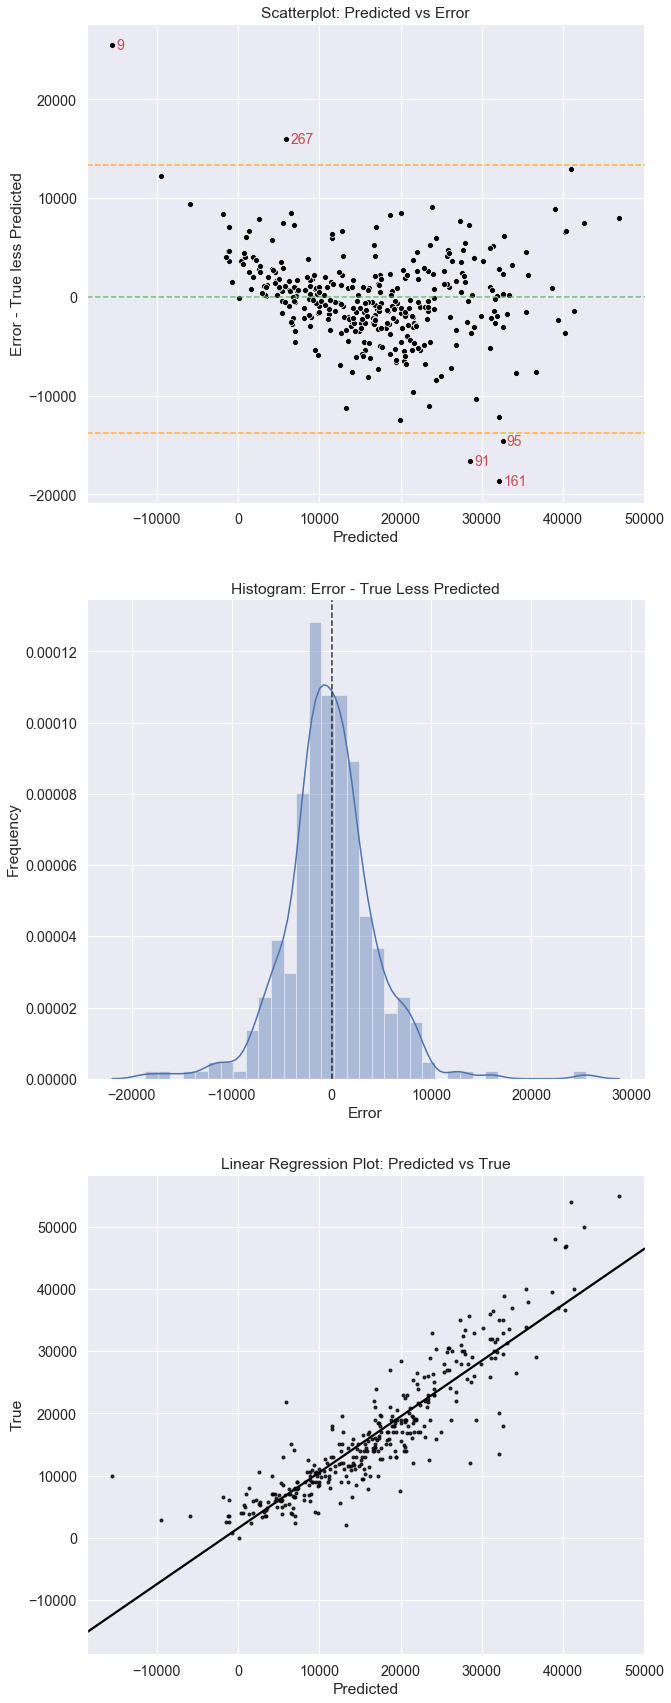

In [43]:
plot_residuals(predicted=y_pred_linregr, true=testY)

In [44]:
rr=Ridge(alpha=0.1, solver='cholesky')  #no scaling required for closed-form solution
rr.fit(trainX, trainY)
y_pred_rr=rr.predict(testX)
score_algo(rr, testX, testY, y_pred_rr)

-----------------------------------------------
##### Ridge - Prediction Scores:
-----------------------------------------------
RMSE: 4793.6
 R^2: 0.774
 MAE: 3278.9


C:\Users\Justin\Anaconda3\envs\ds_env\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.5806e-22): result may not be accurate.
  overwrite_a=True).T


error count: 346 | error avg: -97.5 | high pred percent: 53.2 | low pred percent: 46.8


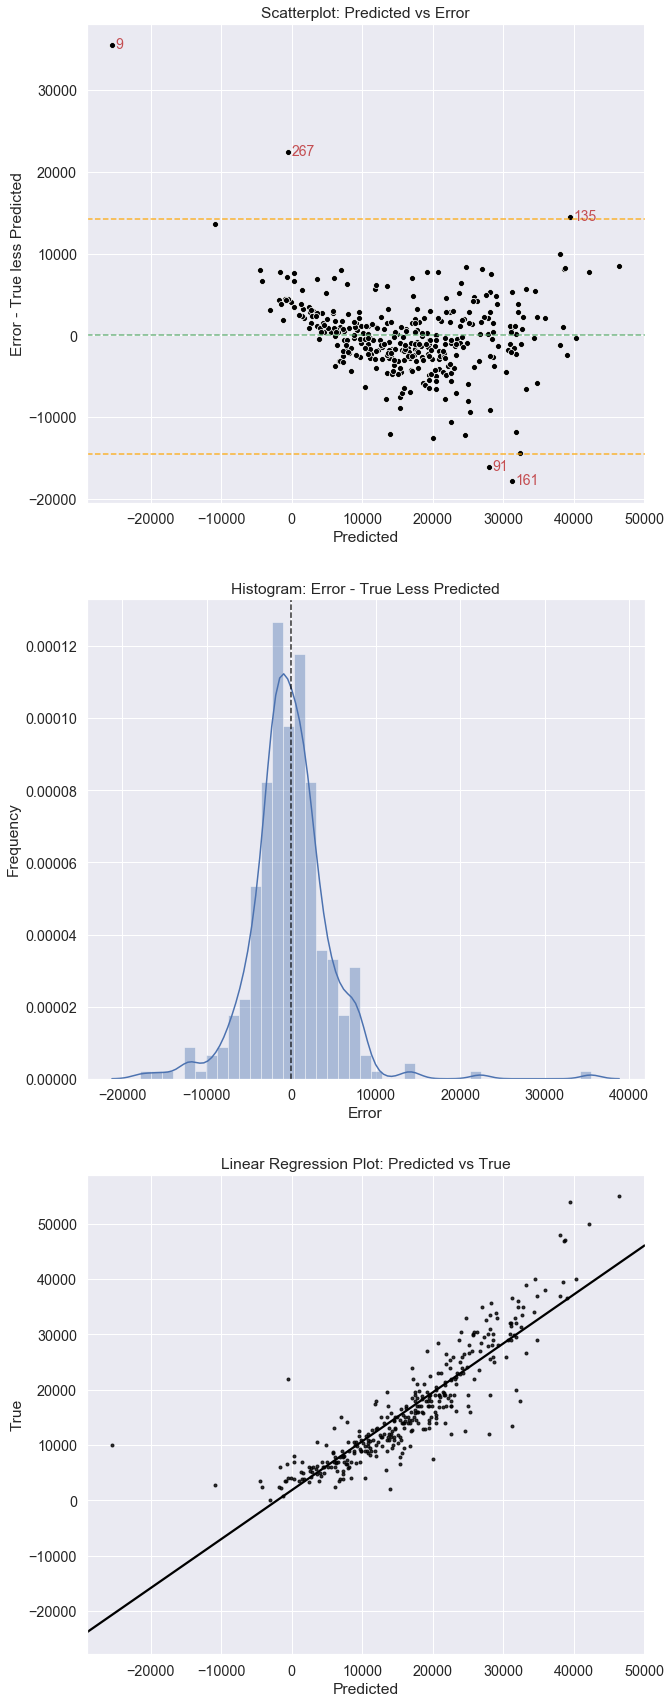

In [45]:
plot_residuals(predicted=y_pred_rr, true=testY)

In [46]:
#Row to Column ratios.
print('train shape:', trainX.shape, '| row/col ratio:', round(trainX.shape[0]/trainX.shape[1],1))
print('test shape:', testX.shape, '| row/col ratio:', round(testX.shape[0]/testX.shape[1],1))

train shape: (3112, 160) | row/col ratio: 19.4
test shape: (346, 160) | row/col ratio: 2.2


In [47]:
trainX.head()

,Year,Odometer,Year^2,Year_Odometer,Location_austin,Location_dallas,Location_elpaso,Location_houston,Location_sanantonio,Model_edge,Model_escape,Model_expedition,Model_explorer,Model_f-150,Model_f-250,Model_f-350,Model_fiesta,Model_focus,Model_fusion,Model_mustang,Model_transit,Trim_4x4,Trim_cargo,Trim_connect,Trim_convertible,Trim_coupe,Trim_diesel,Trim_ecoboost,Trim_eddie,Trim_edge,Trim_fx2,Trim_fx4,Trim_gt,Trim_king,Trim_lariat,Trim_limited,Trim_platinum,Trim_se,Trim_sport,Trim_super,Trim_super duty,Trim_supercab,Trim_supercrew,Trim_titanium,Trim_xl,Trim_xlt,Seller_dealer,Seller_owner,Model_Trim_edge_edge,Model_Trim_escape_se,Model_Trim_escape_titanium,Model_Trim_expedition_eddie,Model_Trim_expedition_limited,Model_Trim_expedition_xlt,Model_Trim_explorer_limited,Model_Trim_explorer_sport,Model_Trim_explorer_xlt,Model_Trim_f-150_4x4,Model_Trim_f-150_fx2,Model_Trim_f-150_fx4,Model_Trim_f-150_king,Model_Trim_f-150_lariat,Model_Trim_f-150_platinum,Model_Trim_f-150_super,Model_Trim_f-150_supercab,Model_Trim_f-150_supercrew,Model_Trim_f-150_xl,Model_Trim_f-150_xlt,Model_Trim_f-250_diesel,Model_Trim_f-250_king,Model_Trim_f-250_lariat,Model_Trim_f-250_super,Model_Trim_f-250_super duty,Model_Trim_f-250_xlt,Model_Trim_f-350_super,Model_Trim_f-350_super duty,Model_Trim_fiesta_se,Model_Trim_focus_se,Model_Trim_fusion_se,Model_Trim_fusion_titanium,Model_Trim_mustang_convertible,Model_Trim_mustang_coupe,Model_Trim_mustang_ecoboost,Model_Trim_mustang_gt,Model_Trim_transit_cargo,Model_Trim_transit_connect,Model_Seller_edge_dealer,Model_Seller_edge_owner,Model_Seller_escape_dealer,Model_Seller_escape_owner,Model_Seller_expedition_dealer,Model_Seller_expedition_owner,Model_Seller_explorer_dealer,Model_Seller_explorer_owner,Model_Seller_f-150_dealer,Model_Seller_f-150_owner,Model_Seller_f-250_dealer,Model_Seller_f-250_owner,Model_Seller_f-350_dealer,Model_Seller_f-350_owner,Model_Seller_fiesta_dealer,Model_Seller_fiesta_owner,Model_Seller_focus_dealer,Model_Seller_focus_owner,Model_Seller_fusion_dealer,Model_Seller_fusion_owner,Model_Seller_mustang_dealer,Model_Seller_mustang_owner,Model_Seller_transit_dealer,Model_Seller_transit_owner,Trim_Seller_4x4_dealer,Trim_Seller_4x4_owner,Trim_Seller_cargo_dealer,Trim_Seller_cargo_owner,Trim_Seller_connect_dealer,Trim_Seller_connect_owner,Trim_Seller_convertible_dealer,Trim_Seller_convertible_owner,Trim_Seller_coupe_dealer,Trim_Seller_coupe_owner,Trim_Seller_diesel_dealer,Trim_Seller_diesel_owner,Trim_Seller_ecoboost_dealer,Trim_Seller_ecoboost_owner,Trim_Seller_eddie_dealer,Trim_Seller_eddie_owner,Trim_Seller_edge_dealer,Trim_Seller_edge_owner,Trim_Seller_fx2_dealer,Trim_Seller_fx2_owner,Trim_Seller_fx4_dealer,Trim_Seller_fx4_owner,Trim_Seller_gt_dealer,Trim_Seller_gt_owner,Trim_Seller_king_dealer,Trim_Seller_king_owner,Trim_Seller_lariat_dealer,Trim_Seller_lariat_owner,Trim_Seller_limited_dealer,Trim_Seller_limited_owner,Trim_Seller_platinum_dealer,Trim_Seller_platinum_owner,Trim_Seller_se_dealer,Trim_Seller_se_owner,Trim_Seller_sport_dealer,Trim_Seller_sport_owner,Trim_Seller_super duty_dealer,Trim_Seller_super duty_owner,Trim_Seller_super_dealer,Trim_Seller_super_owner,Trim_Seller_supercab_dealer,Trim_Seller_supercab_owner,Trim_Seller_supercrew_dealer,Trim_Seller_supercrew_owner,Trim_Seller_titanium_dealer,Trim_Seller_titanium_owner,Trim_Seller_xl_dealer,Trim_Seller_xl_owner,Trim_Seller_xlt_dealer,Trim_Seller_xlt_owner
5764,2016,55843.0,4064256,112579488.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

### `K-Nearest Neighbors Regressor`

In [48]:
trainXS, testXS = scale_num_df(trainX, testX, trainX.columns, RobustScaler())
print('scaler:', type(RobustScaler()).__name__)
print('*******************************************************************\n')

for k in range(3,11):    
    print(f'k={k}:')
    #Train and Score KNN Regressor
    knn=KNeighborsRegressor(n_neighbors=k)
    knn.fit(trainXS, trainY)

    #Predict
    y_pred_kneigh=knn.predict(testXS)
    score_algo(knn, testXS, testY, y_pred_kneigh)
    print('-------------------------------------------------------------------\n')

scaler: RobustScaler
*******************************************************************

k=3:
-----------------------------------------------
##### KNeighborsRegressor - Prediction Scores:
-----------------------------------------------
RMSE: 4138.0
 R^2: 0.8316
 MAE: 2860.5
-------------------------------------------------------------------

k=4:
-----------------------------------------------
##### KNeighborsRegressor - Prediction Scores:
-----------------------------------------------
RMSE: 3927.7
 R^2: 0.8483
 MAE: 2710.4
-------------------------------------------------------------------

k=5:
-----------------------------------------------
##### KNeighborsRegressor - Prediction Scores:
-----------------------------------------------
RMSE: 3954.4
 R^2: 0.8462
 MAE: 2808.8
-------------------------------------------------------------------

k=6:
-----------------------------------------------
##### KNeighborsRegressor - Prediction Scores:
------------------------------------------

In [49]:
#Target encoding for KNN
train_tenc, test_tenc=target_encode_categorical(train,test,'Price', TargetEncoder(cols=encode_cols,smoothing=0.05))

#Target Encoded Features - Split out Price
trainX_tenc = train_tenc.copy()
trainY_tenc =trainX_tenc.pop('Price')
testX_tenc = test_tenc.copy()
testY_tenc =testX_tenc.pop('Price')

#Scale
trainXS, testXS = scale_num_df(trainX_tenc, testX_tenc, trainX_tenc.columns, RobustScaler())
print('scaler:', type(RobustScaler()).__name__)

scaler: RobustScaler


In [50]:
# for k in range(3,11):    
#     print(f'k={k}:')
#     #Train and Score KNN Regressor
#     knn=KNeighborsRegressor(n_neighbors=k)
#     knn.fit(trainXS, trainY)

#     #Predict
#     y_pred_kneigh=knn.predict(testXS)
#     score_algo(knn, testXS, testY, y_pred_kneigh)
#     print('-------------------------------------------------------------------\n')

### `SVR Regressor`

In [51]:
from sklearn.svm import SVR

#Instantiate
svr = SVR(kernel = 'linear', C=150, gamma='scale', epsilon=0.3)

#Fit
svr.fit(trainXS, trainY)

#Predict
y_pred_svr=svr.predict(testXS)
print('\n')      
score_algo(svr, testXS, testY, y_pred_svr) 



-----------------------------------------------
##### SVR - Prediction Scores:
-----------------------------------------------
RMSE: 5240.2
 R^2: 0.7299
 MAE: 3632.8


In [52]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor

In [53]:
#Generic Random Forest with defaults
rfr = RandomForestRegressor()
rfr.fit(trainXS, trainY)
pred_rfr = rfr.predict(testXS)
score_algo(rfr, testXS, testY, pred_rfr)

-----------------------------------------------
##### RandomForestRegressor - Prediction Scores:
-----------------------------------------------
RMSE: 3600.8
 R^2: 0.8725
 MAE: 2392.4


In [54]:
#LGB on standardized data hyperparameters.
lgbr = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression',silent=1)
lgbr.fit(trainXS, trainY)
pred_lgbr = lgbr.predict(testXS)
score_algo(lgbr, testXS, testY, pred_lgbr)

-----------------------------------------------
##### LGBMRegressor - Prediction Scores:
-----------------------------------------------
RMSE: 3584.9
 R^2: 0.8736
 MAE: 2405.0


In [55]:
#BENCHMARK -- LGB on custom data and hyperparameters.
lgbr_tuned = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression',silent=1, **best_hyperparams)
lgbr_tuned.fit(trainX_lenc, trainY_lenc)
pred_lgbr_tuned = lgbr_tuned.predict(testX_lenc)
score_algo(lgbr_tuned, testX_lenc, testY_lenc, pred_lgbr_tuned)

-----------------------------------------------
##### LGBMRegressor - Prediction Scores:
-----------------------------------------------
RMSE: 3389.4
 R^2: 0.887
 MAE: 2338.9


In [56]:
#Do stacking regressor.  Pick base estimators and meta-estimator.
#Passthrough includes original training data for meta-estimator, not just base predictions.

baseEst = [('knn', KNeighborsRegressor(n_neighbors=4)),
           ('rr:', Ridge(alpha=0.01)),
           #('svr:', SVR(kernel = 'linear', C=150, gamma='scale', epsilon=0.3)),
           ('lgbr', lgb.LGBMRegressor(boosting_type='gbdt', objective='regression')),
          ]

metaEst = LinearRegression(fit_intercept=True)

stack = StackingRegressor(estimators=baseEst, final_estimator=metaEst, passthrough=False)

stack.fit(trainXS, trainY)
pred_stack = stack.predict(testXS)
score_algo(stack, testXS, testY, pred_stack)

-----------------------------------------------
##### StackingRegressor - Prediction Scores:
-----------------------------------------------
RMSE: 3499.4
 R^2: 0.8796
 MAE: 2357.5


In [57]:
trainXS.head()

,Location,Year,Odometer,Make,Model,Trim,Seller,Model_Trim,Model_Seller,Trim_Seller,Year^2,Year_Odometer
5764,-0.217472,0.333333,-0.459860,0.0,0.000000,0.000000,0.000000,0.212403,0.285417,0.089994,0.333665,-0.460962
3229,0.000000,0.333333,-0.552880,0.0,-1.000000,-1.014615,0.000000,-0.698944,-0.374127,-0.868290,0.333665,-0.554418
7541,-0.217472,-0.333333,0.404820,0.0,-2.856634,-1.014615,0.000000,-1.788007,-1.088741,-0.868290,-0.333333,0.404858
1746,0.000000,0.166667,-0.149152,0.0,-0.605782,0.028904,-7404.775719,-0.111772,-0.663613,-0.565424,0.166791,-0.149251
5654,-0.217472,0.333333,-0.275878,0.0,0.000000,0.596743,0.000000,0.170726,0.285417,0.672830,0.333665,-0.276118


In [58]:
end = time.time()
print('Minutes Elapsed:', round((end-start)/60,2))

Minutes Elapsed: 0.3


In [59]:
# #Replicated skopt log-uniform function.  But, don't know how to specify number of iterations!
# def log10_uniform(lower=1e-9, upper=1, drawsize=1, rand_state=42):
#     '''Sample uniform points between log10(lower) and log10(upper).
#     Returns generator object for float64 values when size=None'''
#     low = np.log10(lower)
#     upp = np.log10(upper)
#     scaleval=upp-low
#     print(scaleval)
#     yield np.exp(uniform.rvs(loc=low, scale=scaleval, size=drawsize, random_state=rand_state))